#### code for Combined Chart + Normal Features DNN

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Masking, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import model_from_json
from keras.callbacks import History, CSVLogger
from keras.utils import plot_model
import keras.backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import pickle
csv_logger = CSVLogger('training.log')

/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [30]:
#below can path can be set to any folder if extracting Phenotype score rather than using pre-extracted.
phenotype_features = '/Users/rajeshpothamsetty/Dropbox/Rajesh_DB/IMP_Dropbox/OMSCS/BigData/' #phenotype
#below are results folders from Scala/Spark
feature_chart_normf = '/Users/rajeshpothamsetty/Downloads/Results_update/all_features/' #mengnan

In [31]:
phenotype_train = pd.read_csv( phenotype_features +'phenotype_train.csv', delimiter=",", header= 0)[['ICUSTAY_ID', 'Phentotype_Score']]
phenotype_test = pd.read_csv( phenotype_features +'phenotype_test.csv', delimiter=",", header= 0)[['ICUSTAY_ID', 'Phentotype_Score']]

In [32]:
seed = 7
np.random.seed(seed)

In [33]:
dataset_df = pd.read_csv(feature_chart_normf +"feature_value_with_masks.txt", delimiter=",", header= None)

In [34]:
dataset_df[0].replace('', np.nan, inplace=True)
dataset_df.dropna(subset=[0], inplace=True)
dataset_df[0] = pd.to_numeric(dataset_df[0])
dataset_df[0] = dataset_df[0].astype(int)

In [35]:
dataset_df.head()
colnames = dataset_df.columns
dataset_df = dataset_df.rename(columns = {0 : 'ICUSTAY_ID'}) 

In [36]:
# merging to separate train/test
dataset_train_merge = pd.merge(dataset_df, phenotype_train, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')
dataset_test_merge = pd.merge(dataset_df, phenotype_test, how = 'inner', left_on = 'ICUSTAY_ID', right_on = 'ICUSTAY_ID')

In [37]:
dataset_train = dataset_train_merge.values
dataset_test = dataset_test_merge.values

In [38]:
Y1 = dataset_train[:,5367]
X1 = np.delete(dataset_train, 5367, axis=1)
X1 = np.delete(X1, 0, axis=1)

In [39]:
X1[X1 == np.nan] = '-10'
X1 = X1.astype(float)
Y1[Y1 == ''] = '0.0'
Y1 = Y1.astype(float)

/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
from numpy import *
X1[isnan(X1)] = '-10'
X1 = X1.astype(float)

In [41]:
print(X1.shape)

(35942, 13045)


Nesterov momentum is a different version of the momentum method which has stronger theoretical converge guarantees for convex functions. In practice, it works slightly better than standard momentum.  
Need to look in to optimal lr for dropout (i think gridsearch will figure this out)

In the original paper on dropout, it is recommended to have constraint on maximum norm of the weights

#####tips for performance increment with dropout
Good to have larger networks when using dropout.    
dropout between each layers
Use a large learning rate with decay and a large momentum. Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99.
Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights such as max-norm regularization with a size of 4 or 5 has been shown to improve results.

In [42]:
def create_model_with_dropout_new(loss, optimizer, init, learning_rate = 0, decay = 0, momentum = 0.8, dropout = 0.2):

    def weighted_binary_crossentropy(y_true, y_pred):
        one_weight = 0.91
        zero_weight = 0.09
        b_ce = binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)

    # create model
    model = Sequential()
    model.add(Dropout(dropout, input_shape=(13045,)))
    model.add(Dense(6000, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(3000, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(1500, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout))
    model.add(Dense(700, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(300, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(100, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(50, kernel_initializer='normal', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
   
    # setting SGD params
    if (optimizer == 'sgd'):
        optim_algo = optimizers.SGD(lr= learning_rate, decay = decay, momentum = momentum, nesterov = True)
    elif (optimizer == 'adam'):
        # Keras default: lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0.
        optim_algo = optimizers.adam(lr = learning_rate, beta_1 = decay, beta_2 = momentum, epsilon = 10E-8)
    else:
        optim_algo = optimizer
        
    # Compile model
    model.compile(loss = weighted_binary_crossentropy, optimizer= optim_algo, metrics=['accuracy', 'mae', 'categorical_accuracy'])
    return model 

In [43]:
# setting up the Grid Params
# In our test runs, 'adam' optimizer was found to be the best optimizer with it's standard settings without much tuning
optimizer_list = ['adam', 'sgd'] #Adadelta, Adagrad
init_list = ['glorot_uniform', 'normal', 'uniform']
loss_list = ['weighted_binary_crossentropy']

In [19]:
#### Including standardization in the GridSearch and CrossValidation process
model = KerasClassifier(build_fn = create_model_with_dropout_new, verbose = 1) # , batch_size = 1000

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('nn', model))
pipeline = Pipeline(estimators)

param_grid_pipe = { 'nn' : [model],
                    'nn__optimizer': ['adam'],
                  'nn__epochs' : [10],
                  'nn__batch_size' : [1000],
                  'nn__init' : ['glorot_uniform'],
                  'nn__loss' : loss_list,
                 'nn__learning_rate' : [0.001],
                  'nn__decay' : [0.9],
                  'nn__momentum' : [0.999]
                  }

#pipeline.get_params().keys()
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid_pipe, n_jobs = 1, cv = 5, refit= True)
grid_result_pipe = grid.fit(X1, Y1)

Epoch 1/10
28753/28753 [==============================] - 155s 5ms/step - loss: 0.0694 - acc: 0.8645 - mean_absolute_error: 0.1858 - categorical_accuracy: 1.0000
Epoch 2/10
28753/28753 [==============================] - 152s 5ms/step - loss: 0.0366 - acc: 0.9210 - mean_absolute_error: 0.1167 - categorical_accuracy: 1.0000
Epoch 3/10
28753/28753 [==============================] - 146s 5ms/step - loss: 0.0278 - acc: 0.9425 - mean_absolute_error: 0.0880 - categorical_accuracy: 1.0000
Epoch 4/10
28753/28753 [==============================] - 154s 5ms/step - loss: 0.0230 - acc: 0.9529 - mean_absolute_error: 0.0727 - categorical_accuracy: 1.0000
Epoch 5/10
28753/28753 [==============================] - 153s 5ms/step - loss: 0.0207 - acc: 0.9592 - mean_absolute_error: 0.0636 - categorical_accuracy: 1.0000
Epoch 6/10
28753/28753 [==============================] - 142s 5ms/step - loss: 0.0189 - acc: 0.9632 - mean_absolute_error: 0.0586 - categorical_accuracy: 1.0000
Epoch 7/10
28753/28753 [====

28754/28754 [==============================] - 158s 5ms/step - loss: 0.1343 - acc: 0.9322 - mean_absolute_error: 0.0818 - categorical_accuracy: 1.0000
Epoch 9/10
28754/28754 [==============================] - 156s 5ms/step - loss: 0.1331 - acc: 0.9344 - mean_absolute_error: 0.0788 - categorical_accuracy: 1.0000
Epoch 10/10
28754/28754 [==============================] - 47s 2ms/step
Epoch 1/10
35942/35942 [==============================] - 215s 6ms/step - loss: 0.0909 - acc: 0.8612 - mean_absolute_error: 0.1904 - categorical_accuracy: 1.0000
Epoch 2/10
35942/35942 [==============================] - 217s 6ms/step - loss: 0.0372 - acc: 0.9171 - mean_absolute_error: 0.1253 - categorical_accuracy: 1.0000
Epoch 3/10
35942/35942 [==============================] - 217s 6ms/step - loss: 0.0273 - acc: 0.9444 - mean_absolute_error: 0.0877 - categorical_accuracy: 1.0000
Epoch 4/10
35942/35942 [==============================] - 220s 6ms/step - loss: 0.0233 - acc: 0.9530 - mean_absolute_error: 0.072

In [44]:
#Y1_test = dataset_test[:,12927]
Y1_test = dataset_test[:,5367]
Y1_test
X1_test = np.delete(dataset_test, 5367, axis=1)
X1_test = np.delete(X1_test, 0, axis=1)

X1_test[X1_test == ''] = '-10'
X1_test = X1_test.astype(float)
Y1_test[Y1_test == ''] = '0.0'
Y1_test = Y1_test.astype(float)

from numpy import *
X1_test[isnan(X1_test)] = '-10'
X1_test = X1_test.astype(float)
X1_test

Y_test_prob = grid_result_pipe.predict_proba(X1_test)

/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/Users/rajeshpothamsetty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


6605/6605 [==============================] - 24s 4ms/step


In [45]:
dataset_test.shape

(6605, 13047)

In [46]:
#Train Accuracy
y_train_pred = grid.predict(X1)
from sklearn.metrics import *
accuracy_score(Y1, y_train_pred)

35942/35942 [==============================] - 125s 3ms/step


0.9835568415780981

In [47]:
#Test Accuracy
y_test_pred = grid.predict(X1_test)
accuracy_score(Y1_test, y_test_pred)

6605/6605 [==============================] - 21s 3ms/step


0.9801665404996215

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

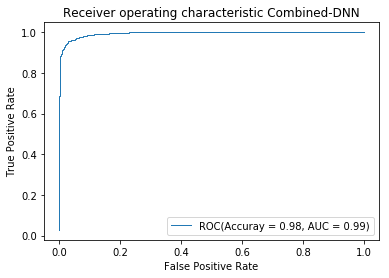

In [52]:
#plotting test roc_curve
fpr, tpr, thresholds = roc_curve(Y1_test, Y_test_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=4, label='ROC(Accuray = %0.2f, AUC = %0.2f)' % (accuracy_score(Y1_test, y_test_pred), roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Combined-DNN')
plt.legend(loc="lower right")
plt.show()